# **Portfolio Optimization & Risk Analysis**

**Description:** This notebook demonstrates a full financial data science workflow for portfolio optimization, backtesting, and stress testing, with a **full financial data science workflow**:
1. Data collection and cleaning
2. Exploratory analysis and visualizations
3. Portfolio optimization with different optimization functions
4. Rebalancing simulation over time
5. Backtesting performance vs benchmark
6. Stress scenario analysis (tech crash & market crash)
7. Interactive and static visualizations

---

## **1. Import Libraries**

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import os
from pathlib import Path
from scipy.linalg import inv
from pypfopt.efficient_frontier import EfficientFrontier
from sklearn.covariance import LedoitWolf

---

## **2. Data Collection**
We gather historical adjusted closing prices for selected assets (stocks + benchmark ETF).

In [ ]:
DATA_DIR = Path('data_opt')
DATA_DIR.mkdir(exist_ok=True)

def load_cached_prices(path):
    """
    Loads price CSVs in a robust way:
    - Handles malformed files (like the sample you posted)
    - Handles clean yfinance CSVs
    """
    try:
        df = pd.read_csv(path, parse_dates=['date'])
        df = df.set_index('date')
    except Exception:
        # CSV is malformed: try fixed loader
        print(f"⚠️ Malformed CSV detected: {path.name}. Attempting recovery...")

        # Skip first two junk rows: ('Ticker', 'AAPL', ...) and the NaN row
        df = pd.read_csv(path, skiprows=2)

        # First column is the date column but unnamed
        df = df.rename(columns={df.columns[0]: 'date'})
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df = df.set_index('date')

    # Clean numeric columns
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Standardize price column
    if 'adj_close' not in df.columns:
        if 'Adj Close' in df.columns:
            df = df.rename(columns={'Adj Close': 'adj_close'})
        elif 'Close' in df.columns:
            df = df.rename(columns={'Close': 'adj_close'})
        else:
            raise ValueError(f"No price column found in cached file: {path}")

    # Drop any fully invalid rows
    df = df.dropna(subset=['adj_close'])

    return df


def download_and_cache(ticker, start='2018-01-01', end='2025-10-01',
                       data_dir=DATA_DIR, force_refresh=False):

    path = data_dir / f'{ticker}.csv'

    if path.exists() and not force_refresh:
        try:
            return load_cached_prices(path)
        except Exception as e:
            print(f"⚠️ Failed to load cached {ticker}.csv, redownloading. Reason: {e}")

    print(f"⬇ Downloading fresh data for {ticker}...")
    df = yf.download(ticker, start=start, end=end, progress=False)

    if df.empty:
        raise ValueError(f"No data returned for ticker {ticker}")

    if 'Adj Close' in df.columns:
        df = df.rename(columns={'Adj Close': 'adj_close'})
    else:
        # If Adj Close unavailable, use Close instead
        df = df.rename(columns={'Close': 'adj_close'})

    df = df.reset_index().rename(columns={'Date': 'date'})
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.set_index('date')

    df.to_csv(path)
    return df

In [6]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'SPY']
all_data = {}

for t in tickers:
    try:
        all_data[t] = download_and_cache(t)
        print(f"{t}: {len(all_data[t])} rows loaded")
    except Exception as e:
        print("❌ Error loading", t, e)

⬇ Downloading fresh data for AAPL...
AAPL: 1947 rows loaded
⬇ Downloading fresh data for MSFT...


C:\Users\min\AppData\Local\Temp\ipykernel_20264\1078821145.py:56: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)
C:\Users\min\AppData\Local\Temp\ipykernel_20264\1078821145.py:56: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


MSFT: 1947 rows loaded
⬇ Downloading fresh data for GOOGL...


C:\Users\min\AppData\Local\Temp\ipykernel_20264\1078821145.py:56: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


GOOGL: 1947 rows loaded
⬇ Downloading fresh data for AMZN...


C:\Users\min\AppData\Local\Temp\ipykernel_20264\1078821145.py:56: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


AMZN: 1947 rows loaded
⬇ Downloading fresh data for TSLA...


C:\Users\min\AppData\Local\Temp\ipykernel_20264\1078821145.py:56: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


TSLA: 1947 rows loaded
⬇ Downloading fresh data for SPY...


C:\Users\min\AppData\Local\Temp\ipykernel_20264\1078821145.py:56: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


SPY: 1947 rows loaded


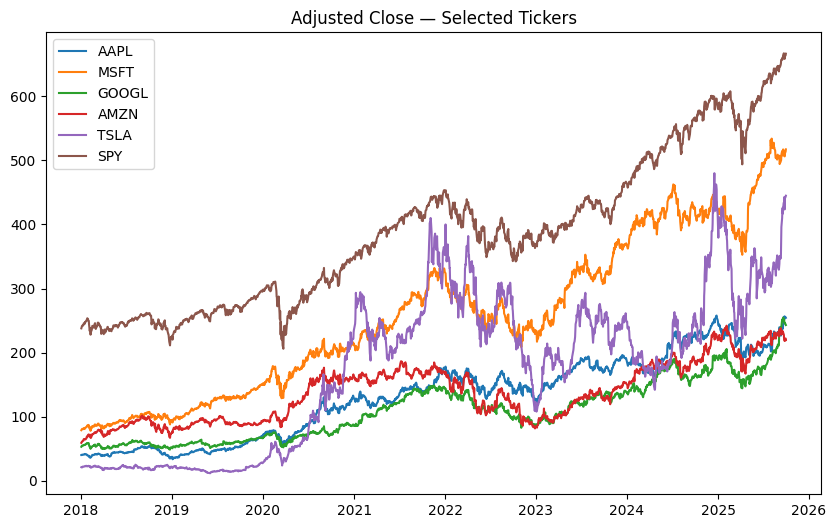

In [7]:
plt.figure(figsize=(10,6))
for t, d in all_data.items():
    plt.plot(d.index, d['adj_close'], label=t)
plt.legend()
plt.title('Adjusted Close — Selected Tickers')
plt.show()

In [8]:
series_list = []

for t in tickers:
    df = all_data[t]
    # pick price column
    if 'adj_close' in df.columns:
        s = df['adj_close'].copy()
    elif 'Close' in df.columns:
        s = df['Close'].copy()
    else:
        raise ValueError(f"No price column found for {t}")
    s.name = t  # set the series name instead of using rename()
    series_list.append(s)

# Combine all series on their indexes (dates)
data = pd.concat(series_list, axis=1)

# Compute daily returns
returns = data.pct_change().dropna()

print("Historical Prices Head:")
print(data.head())
print("\nReturns Head:")
print(returns.head())

Historical Prices Head:
Ticker           AAPL       MSFT      GOOGL       AMZN       TSLA         SPY
date                                                                         
2018-01-02  40.341900  79.050362  53.292931  59.450500  21.368668  237.909225
2018-01-03  40.334866  79.418266  54.202160  60.209999  21.150000  239.413986
2018-01-04  40.522213  80.117256  54.412708  60.479500  20.974667  240.423065
2018-01-05  40.983566  81.110565  55.134232  61.457001  21.105333  242.025177
2018-01-08  40.831348  81.193359  55.328896  62.343498  22.427334  242.467804

Returns Head:
Ticker          AAPL      MSFT     GOOGL      AMZN      TSLA       SPY
date                                                                  
2018-01-03 -0.000174  0.004654  0.017061  0.012775 -0.010233  0.006325
2018-01-04  0.004645  0.008801  0.003885  0.004476 -0.008290  0.004215
2018-01-05  0.011385  0.012398  0.013260  0.016163  0.006230  0.006664
2018-01-08 -0.003714  0.001021  0.003531  0.014425  0.062638

---

## **3. Exploratory Data Analysis**
### **3.1. Correlation heatmap**

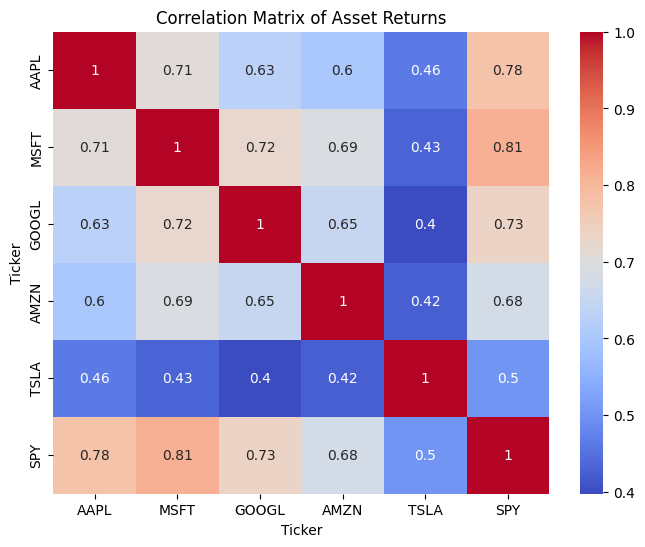

In [9]:
plt.figure(figsize=(8,6))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Asset Returns")
plt.show()

### **3.2. Price evolution**

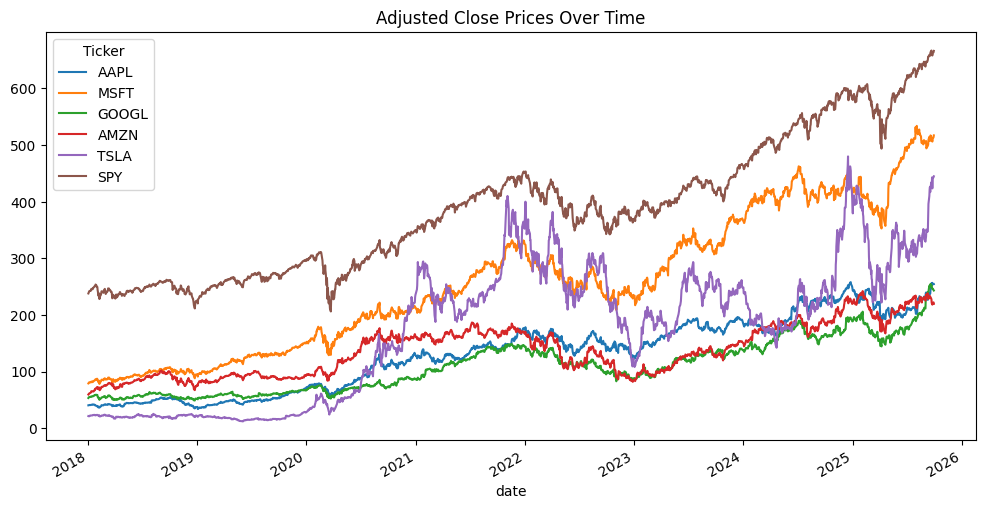

In [10]:
data.plot(figsize=(12,6))
plt.title("Adjusted Close Prices Over Time")
plt.show()

### **3.3. Rolling 30-day volatility**

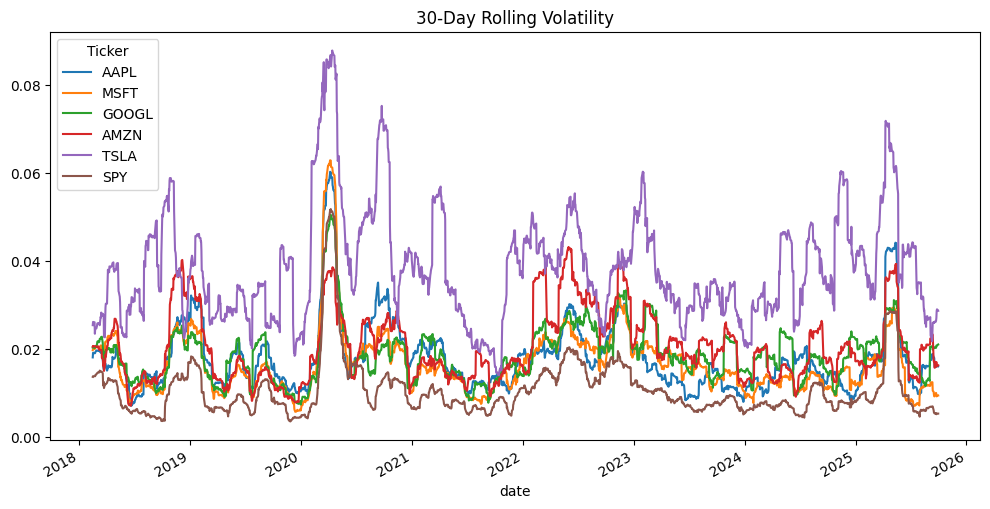

In [11]:
returns.rolling(window=30).std().plot(figsize=(12,6))
plt.title("30-Day Rolling Volatility")
plt.show()

---

## **4. Portfolio Optimization Functions**

### **Portfolio Optimization Strategies**

In modern portfolio management, various optimization approaches can be applied to construct portfolios that align with specific objectives, such as maximizing risk-adjusted returns, minimizing risk, or allocating risk evenly across assets. The following strategies are implemented:

1. **Mean-Variance Optimization (MVO / Max Sharpe Ratio)**

   * This classical approach, introduced by Harry Markowitz, seeks to find portfolio weights that **maximize the Sharpe Ratio**, i.e., the ratio of expected excess return to portfolio volatility.
   * It relies on **expected returns** and the **covariance matrix of asset returns**.
   * Constraints can enforce full investment (weights sum to 1) and restrict shorting (non-negative weights).

2. **Minimum Volatility Portfolio**

   * This strategy targets **the lowest possible portfolio volatility** regardless of expected returns.
   * It is useful for conservative investors who prioritize **risk reduction over return maximization**.
   * Typically, constraints prevent negative weights, ensuring a long-only portfolio.

3. **Risk Parity / Equal Risk Contribution (ERC)**

   * ERC aims to allocate **risk equally across all assets**, rather than capital.
   * Each asset contributes roughly the same amount of **portfolio volatility**.
   * This often produces more diversified portfolios that are **resilient to market shocks** compared with naive or capitalization-weighted portfolios.

4. **Black-Litterman Framework**

   * The Black-Litterman model blends **market equilibrium returns** with **investor views** to produce adjusted expected returns.
   * These posterior returns can then be fed into an optimization routine (e.g., Max Sharpe) to construct a portfolio that **balances market consensus with subjective insights**.
   * This approach is particularly useful when views are uncertain or when combining forward-looking forecasts with historical data.

These strategies offer a spectrum from **pure risk-based allocations** (Min Vol, ERC) to **return-oriented approaches** (MVO, Black-Litterman), depending on the investor’s objectives and risk appetite.

In [12]:
TRADING_DAYS_PER_YEAR = 252
risk_free_rate = 0.02
market_risk_aversion = 2.5 # Delta (λ)
tau = 0.05                 # Uncertainty scalar
rebalance_period = 180  # days
turnover_limit = 0.10
asset_list = returns.columns.tolist()
num_assets = len(asset_list)

In [13]:
# 0. Helper functions

def portfolio_performance(weights, expected_returns, cov_matrix, risk_free_rate):
    """
    Calculates the annual return, volatility, and Sharpe Ratio of a portfolio.
    """
    weights = np.array(weights)
    # Annualized Return (E[R_p])
    portfolio_return = np.dot(weights, expected_returns)
    # Annualized Volatility (sigma_p)
    portfolio_std_dev = np.sqrt(weights.T @ cov_matrix @ weights)
    # Sharpe Ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return portfolio_return, portfolio_std_dev, sharpe_ratio

def neg_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate):
    """
    Objective function to minimize (negative Sharpe Ratio).
    """
    _, _, sharpe_ratio = portfolio_performance(weights, expected_returns, cov_matrix, risk_free_rate)
    return -sharpe_ratio

def portfolio_variance(weights, cov_matrix):
    """Calculates the portfolio variance to be minimized."""
    weights = np.array(weights)
    return weights.T @ cov_matrix @ weights

def calculate_portfolio_volatility(weights, cov_matrix):
    """Calculates portfolio volatility (standard deviation)."""
    return np.sqrt(weights.T @ cov_matrix @ weights)

def calculate_risk_contribution(weights, cov_matrix):
    """Calculates the risk contribution of each asset to the total portfolio volatility."""
    portfolio_volatility = calculate_portfolio_volatility(weights, cov_matrix)
    # Marginal Risk Contribution (MRC) is (Sigma * w) / volatility
    marginal_contrib = np.dot(cov_matrix, weights) / portfolio_volatility
    # Total Risk Contribution (RC) is w * MRC
    risk_contrib = np.multiply(weights, marginal_contrib)
    return risk_contrib

def risk_parity_objective(weights, cov_matrix):
    """Objective function to minimize the difference in risk contributions."""
    risk_contrib = calculate_risk_contribution(weights, cov_matrix)
    # Target Risk Contribution is 1/N for an Equal Risk Contribution portfolio
    # Total portfolio risk is required to scale the target contribution, but
    # a more standard approach is to minimize the squared error relative to the mean.
    # The sum of RCs is equal to the total portfolio volatility, so we target RC_i = RC_j.
    # We minimize the sum of squared differences from the mean contribution.
    target_risk = np.mean(risk_contrib)
    # Minimize the sum of squared errors
    return np.sum((risk_contrib - target_risk) ** 2)

In [14]:
# 1. MVO Optimization Function

def optimize_max_sharpe(expected_returns, cov_matrix, risk_free_rate=0.02):
    """
    Finds the portfolio weights that maximize the Sharpe Ratio (MVO).
    """
    N = len(expected_returns)
    initial_weights = np.array([1/N] * N)
    
    # 1. Constraints (Weights must sum to 1)
    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}  # Sum to 1
    )
    
    # 2. Bounds (Non-negative weights for no shorting)
    bounds = tuple((0, 1) for _ in range(N))
    
    # 3. Optimization
    result = minimize(
        neg_sharpe_ratio,
        initial_weights,
        args=(expected_returns, cov_matrix, risk_free_rate),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        tol=1e-6
    )
    
    if result.success:
        return result.x
    else:
        raise Exception(f"Optimization failed: {result.message}")

In [15]:
# 2. Minimum Volatility Optimizer

def optimize_min_volatility(cov_matrix):
    """Finds the portfolio with the minimum volatility."""
    N = len(cov_matrix)
    initial_weights = np.array([1/N] * N)
    
    # 1. Constraints (Weights must sum to 1, and no shorting)
    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}  # Sum to 1
    )
    
    # 2. Bounds (Non-negative weights for no shorting)
    bounds = tuple((0, 1) for _ in range(N))
    
    # 3. Optimization
    result = minimize(
        portfolio_variance,
        initial_weights,
        args=(cov_matrix,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        tol=1e-6
    )
    
    if result.success:
        return result.x
    else:
        raise Exception(f"Optimization failed: {result.message}")

In [16]:
# 3. Risk Parity (Equal Risk Contribution - ERC)

def optimize_risk_parity(cov_matrix):
    """Finds the portfolio with equal risk contributions."""
    N = len(cov_matrix)
    initial_weights = np.array([1/N] * N)
    
    # Constraints and bounds are the same as Min Vol / MVO
    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}  # Sum to 1
    )
    bounds = tuple((0.001, 1) for _ in range(N)) # Use a tiny lower bound for stability
    
    # Optimization (SLSQP is a good choice for this non-linear problem)
    result = minimize(
        risk_parity_objective,
        initial_weights,
        args=(cov_matrix,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        tol=1e-8 # Often requires higher precision
    )
    
    if result.success:
        return result.x
    else:
        # A common failure is the solution being stuck, consider adjusting tol/method
        raise Exception(f"Optimization failed: {result.message}")

In [17]:
# 4. Corrected Black Litterman Function Definition

def optimize_black_litterman_backtest(window_expected_returns, window_cov_matrix):
    """
    Calculates posterior returns using the core Black-Litterman formula and
    then optimizes for the Maximum Sharpe Ratio.
    """
    asset_list = window_cov_matrix.columns.tolist() 
    num_assets = len(asset_list)
    
    # 1. Inputs
    # The input window_cov_matrix is already annualized and Ledoit-Wolf stabilized from the caller
    Sigma = window_cov_matrix.values
    
    # 2. Regularization: Ensure matrix is invertible
    epsilon = 1e-7 # Apply regularization directly to Sigma
    np.fill_diagonal(Sigma, Sigma.diagonal() + epsilon) 
    
    # 3. Calculate Market-Implied Prior Returns (Π)
    market_weights = np.array(num_assets * [1./num_assets])
    # Formula: Π = λ * Σ * w_m
    Pi = market_risk_aversion * Sigma.dot(market_weights)
    
    # 4. Define Views (Q and P) - Using Static Placeholder Views
    views = [0.15, 0.03] 
    Q = np.array(views).reshape(-1, 1) # Kx1 vector
    K = len(views)
    
    # Picking Matrix P (KxN)
    P = np.zeros((K, num_assets))
    P[0, 0] = 1
    P[1, 1] = 1
    P[1, 2] = -1
    
    # 5. Calculate View Uncertainty Matrix (Ω) Inverse
    omega_diag = np.diag(P.dot(tau * Sigma).dot(P.T))
    Omega_inv = np.diag(1.0 / omega_diag)

    # 6. Core Black-Litterman Formula (Calculate Posterior Returns E[R])
    tau_Sigma_inv = inv(tau * Sigma)
    Term1_inv = tau_Sigma_inv + P.T.dot(Omega_inv).dot(P)
    Term2 = tau_Sigma_inv.dot(Pi.reshape(-1, 1)) + P.T.dot(Omega_inv).dot(Q)
    
    # Posterior Returns E[R]
    bl_returns_array = inv(Term1_inv).dot(Term2).flatten()
    
    # 7. Optimize Max Sharpe using Posterior Returns
    bl_returns = pd.Series(bl_returns_array, index=asset_list)
    
    ef = EfficientFrontier(bl_returns, window_cov_matrix, weight_bounds=(0, 1))
    ef.max_sharpe(risk_free_rate=risk_free_rate)
    
    return pd.Series(ef.clean_weights()).values

---

## **5. Portfolio Rebalancing Simulation**
This function is for **simulating a portfolio over time using different optimization strategies**, showing how the portfolio would perform if it were periodically rebalanced. It calculates portfolio weights at each rebalance, applies them to actual returns, and tracks cumulative performance compared to a benchmark, all while accounting for realistic constraints like turnover limits.

Essentially, it lets us **test and compare different portfolio optimization methods in a dynamic, realistic setting**.

In [18]:
# Create the asset-only DataFrame for optimization
asset_returns = returns.drop(columns=['SPY'])

In [19]:
def run_rebalancing_simulation(optimization_name, rebalance_period, returns, risk_free_rate, turnover_limit, benchmark_data):
    """Runs a rebalancing backtest for a specified optimization strategy."""
    
    weights_history = []
    portfolio_returns = []
    
    asset_list = returns.columns.tolist()
    num_assets = len(asset_list)
    
    if optimization_name == 'MVO':
        opt_func = lambda mu, cov: optimize_max_sharpe(mu, cov, risk_free_rate)
        requires_mu = True
    elif optimization_name == 'Min Vol':
        opt_func = lambda cov: optimize_min_volatility(cov)
        requires_mu = False
    elif optimization_name == 'Risk Parity':
        opt_func = lambda cov: optimize_risk_parity(cov)
        requires_mu = False
    elif optimization_name == 'Black-Litterman':
        opt_func = optimize_black_litterman_backtest
        requires_mu = False
    else:
        raise ValueError(f"Unknown optimizer: {optimization_name}")

    prev_weights = np.array(num_assets * [1./num_assets]) 

    for start in range(0, len(returns), rebalance_period):
        end = min(start + rebalance_period, len(returns))
        window_returns = returns.iloc[start:end]
        
        window_cov_matrix = window_returns.cov() * TRADING_DAYS_PER_YEAR
        window_expected_returns = window_returns.mean() * TRADING_DAYS_PER_YEAR

        if optimization_name == 'Black-Litterman':
            optimal_weights = opt_func(window_expected_returns, window_cov_matrix)
        elif requires_mu:  # Only MVO
            optimal_weights = opt_func(window_expected_returns, window_cov_matrix)
        else:  # Min Vol / Risk Parity
            optimal_weights = opt_func(window_cov_matrix)

        optimal_weights = optimal_weights[:num_assets] 
        adjusted_weights = np.clip(optimal_weights, prev_weights - turnover_limit, prev_weights + turnover_limit)
        adjusted_weights /= np.sum(adjusted_weights) # Re-normalize
        weights_history.append(adjusted_weights)
        
        # Use the actual daily returns within the period and the adjusted weights
        period_daily_returns = window_returns.dot(adjusted_weights) 
        period_return = (1 + period_daily_returns).prod() - 1
        portfolio_returns.append(period_return)
        
        # Update weights for the next period
        prev_weights = adjusted_weights

    weights_history = np.array(weights_history)
    portfolio_returns = np.array(portfolio_returns)
    portfolio_cum_returns = (1 + portfolio_returns).cumprod()
    
    # Get benchmark returns at the same frequency
    benchmark_cum_returns = (1 + benchmark_data['SPY']).cumprod().iloc[::rebalance_period].values[:len(portfolio_cum_returns)]
    
    return portfolio_cum_returns, benchmark_cum_returns, weights_history

In [20]:
all_cumulative_returns = {}
all_weights_history = {}

optimizer_list = ['MVO', 'Min Vol', 'Risk Parity', 'Black-Litterman']

for optimizer in optimizer_list:
    print(f"Running simulation for: {optimizer}")
    # Capture weights_history here (the third return value)
    cum_returns, _, weights_history = run_rebalancing_simulation(
        optimizer, 
        rebalance_period, 
        asset_returns, 
        risk_free_rate, 
        turnover_limit,
        benchmark_data=returns 
    )
    all_cumulative_returns[optimizer] = cum_returns
    all_weights_history[optimizer] = weights_history

Running simulation for: MVO
Running simulation for: Min Vol
Running simulation for: Risk Parity
Running simulation for: Black-Litterman


---

## **6. Backtesting Portfolio vs Benchmark**

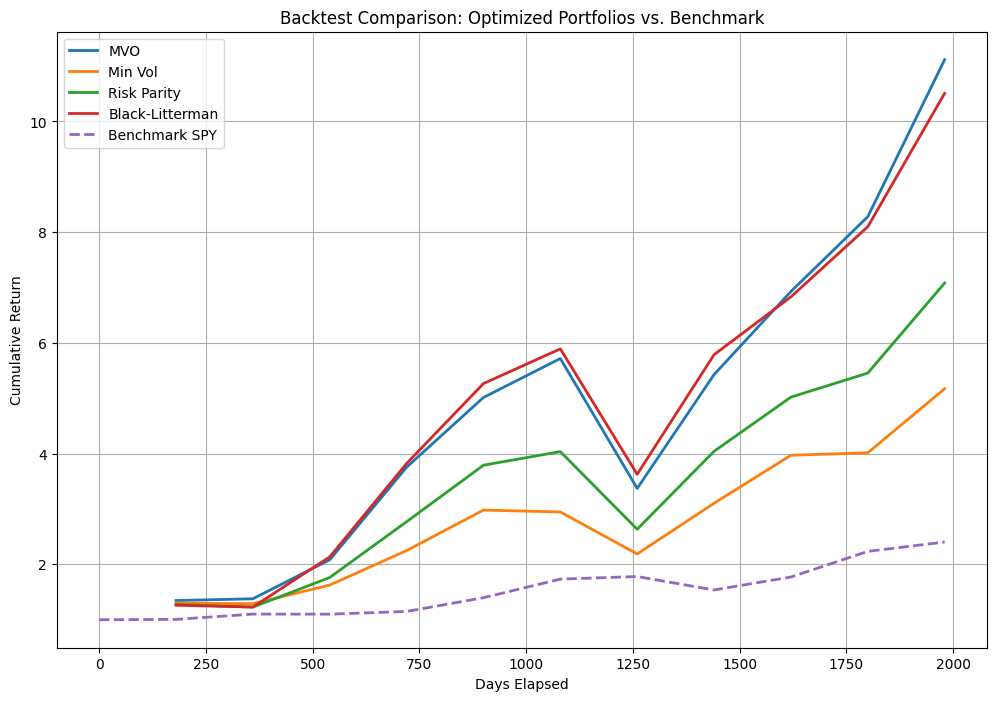

In [21]:
plt.figure(figsize=(12, 8))

for name, cum_returns in all_cumulative_returns.items():
    # Create time steps: [90, 180, 270, ...]
    time_steps = np.arange(1, len(cum_returns) + 1) * rebalance_period
    plt.plot(time_steps, cum_returns, label=name, linewidth=2)

# Note: We pass the original 'returns' DataFrame as benchmark_data
_, benchmark_cum_returns, _ = run_rebalancing_simulation(
    'MVO', rebalance_period, asset_returns, risk_free_rate, turnover_limit, benchmark_data=returns
)
N = len(benchmark_cum_returns)

# Y-axis data: Insert initial cumulative return of 1.0 at the start
benchmark_plot_data = np.insert(benchmark_cum_returns, 0, 1) 

# X-axis data: Create N+1 time steps starting at 0
benchmark_x_axis = np.arange(N + 1) * rebalance_period

plt.plot(benchmark_x_axis, benchmark_plot_data, label='Benchmark SPY', linewidth=2, linestyle='--')

plt.title('Backtest Comparison: Optimized Portfolios vs. Benchmark')
plt.xlabel('Days Elapsed')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)

In [22]:
print("Mean returns:")
print(returns.mean())
print("\nCovariance matrix:")
print(returns.cov())

Mean returns:
Ticker
AAPL     0.001139
MSFT     0.001128
GOOGL    0.000971
AMZN     0.000907
TSLA     0.002373
SPY      0.000606
dtype: float64

Covariance matrix:
Ticker      AAPL      MSFT     GOOGL      AMZN      TSLA       SPY
Ticker                                                            
AAPL    0.000385  0.000250  0.000241  0.000256  0.000366  0.000189
MSFT    0.000250  0.000325  0.000255  0.000270  0.000315  0.000182
GOOGL   0.000241  0.000255  0.000382  0.000276  0.000314  0.000178
AMZN    0.000256  0.000270  0.000276  0.000472  0.000372  0.000182
TSLA    0.000366  0.000315  0.000314  0.000372  0.001633  0.000251
SPY     0.000189  0.000182  0.000178  0.000182  0.000251  0.000153


In [23]:
def calculate_backtest_metrics(returns_df, weights_history, rebalance_period, risk_free_rate, TRADING_DAYS_PER_YEAR=252):
    """
    Reconstructs the daily portfolio returns using historical weights 
    and calculates detailed performance metrics.
    """
    
    all_daily_returns = []
    
    # Reconstruct Daily Portfolio Returns
    for i in range(len(weights_history)):
        start_index = i * rebalance_period
        end_index = min((i + 1) * rebalance_period, len(returns_df))
        
        daily_period_returns = returns_df.iloc[start_index:end_index]
        period_weights = weights_history[i]
        
        # Calculate daily portfolio returns: R_p = R_assets @ W
        daily_portfolio_returns = daily_period_returns.dot(period_weights)
        all_daily_returns.append(daily_portfolio_returns)
        
    portfolio_daily_returns = pd.concat(all_daily_returns)
    
    # Annual Return
    annual_return = (1 + portfolio_daily_returns.mean())**TRADING_DAYS_PER_YEAR - 1
    
    # Annual Volatility
    annual_volatility = portfolio_daily_returns.std() * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Sharpe Ratio
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility
    
    # Max Drawdown
    cumulative_returns = (1 + portfolio_daily_returns).cumprod()
    peak = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    # Sortino Ratio (using 0% as Minimum Acceptable Return, or MAR)
    downside_returns = portfolio_daily_returns[portfolio_daily_returns < 0]
    downside_deviation = downside_returns.std() * np.sqrt(TRADING_DAYS_PER_YEAR)
    sortino_ratio = (annual_return - 0) / downside_deviation
    
    
    return pd.Series({
        'Annual Return': annual_return,
        'Annual Volatility': annual_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown': max_drawdown
    })

In [24]:
results = {}

for name, weights_history in all_weights_history.items():
    metrics = calculate_backtest_metrics(
        asset_returns, 
        weights_history, 
        rebalance_period, 
        risk_free_rate
    )
    results[name] = metrics
metrics_df = pd.DataFrame(results).T

In [25]:
# Calculate metrics for the SPY Benchmark (using the original returns DataFrame)
# We calculate its metrics separately since it's a single ticker
spy_daily_returns = returns['SPY'].dropna()
spy_metrics = {
    'Annual Return': (1 + spy_daily_returns.mean())**TRADING_DAYS_PER_YEAR - 1,
    'Annual Volatility': spy_daily_returns.std() * np.sqrt(TRADING_DAYS_PER_YEAR),
}

spy_metrics['Sharpe Ratio'] = (spy_metrics['Annual Return'] - risk_free_rate) / spy_metrics['Annual Volatility']

spy_cumulative_returns = (1 + spy_daily_returns).cumprod()
spy_peak = spy_cumulative_returns.expanding().max()
spy_max_drawdown = (spy_cumulative_returns / spy_peak - 1).min()
spy_metrics['Max Drawdown'] = spy_max_drawdown

spy_downside_returns = spy_daily_returns[spy_daily_returns < 0]
spy_downside_deviation = spy_downside_returns.std() * np.sqrt(TRADING_DAYS_PER_YEAR)
spy_metrics['Sortino Ratio'] = (spy_metrics['Annual Return'] - 0) / spy_downside_deviation

metrics_df.loc['Benchmark SPY'] = pd.Series(spy_metrics)

In [26]:
print("--- Performance Metrics Comparison (Annualized) ---")
print(metrics_df.to_string())

--- Performance Metrics Comparison (Annualized) ---
                 Annual Return  Annual Volatility  Sharpe Ratio  Sortino Ratio  Max Drawdown
MVO                   0.432952           0.309587      1.333882       1.922974     -0.494523
Min Vol               0.279592           0.260043      0.998264       1.473524     -0.367504
Risk Parity           0.340294           0.280812      1.140601       1.649957     -0.436837
Black-Litterman       0.424630           0.314271      1.287520       1.868617     -0.477243
Benchmark SPY         0.164947           0.196468      0.737761       1.024385     -0.337173


### **Normal Market Performance Analysis**

The results under normal market conditions reveal the inherent design and effectiveness of each portfolio strategy when their optimization assumptions hold true. The annualized metrics are based on the original returns data before any crash simulations.

#### **1. Risk-Adjusted Returns (Sharpe & Sortino Ratios)**

The primary goal of most portfolio optimization is to maximize risk-adjusted returns, and the results clearly reflect this:

* **MVO Dominates:** The **Mean-Variance Optimization (MVO)** portfolio achieves the highest **Sharpe Ratio ($\mathbf{1.33}$)** and **Sortino Ratio ($\mathbf{1.92}$)**. This is expected, as MVO is explicitly designed to maximize the Sharpe Ratio. It is the most efficient portfolio for generating return per unit of total risk and per unit of downside risk.
* **Black-Litterman is Competitive:** **Black-Litterman ($\text{Sharpe}=1.29$, $\text{Sortino}=1.87$)** is a close second. This indicates that incorporating investor views (or implied views in a backtest setting) allows the portfolio to be nearly as efficient as the purely data-driven MVO.
* **Benchmark is Least Efficient:** The **Benchmark SPY** has the lowest Sharpe Ratio ($\mathbf{0.74}$) and Sortino Ratio ($\mathbf{1.02}$) among all entries, confirming that passive investing is significantly less efficient in capturing risk-adjusted returns compared to optimized strategies.

#### **2. Return and Volatility**

| Portfolio | Annual Return | Annual Volatility | Max Drawdown | Key Takeaway |
| :--- | :--- | :--- | :--- | :--- |
| **MVO** | **$43.30\%$** | $30.96\%$ | $-49.45\%$ | Highest return, highest risk. |
| **Min Vol** | $27.96\%$ | **$26.00\%$** | $-36.75\%$ | Lowest volatility. |
| **Risk Parity** | $34.03\%$ | $28.08\%$ | $-43.68\%$ | Balanced, moderate performance. |
| **Benchmark SPY** | $16.49\%$ | **$19.65\%$** | **$-33.72\%$** | Lowest absolute risk (Volatility & Drawdown). |

* **Trade-off between MVO and Min Vol:** MVO delivers the highest absolute return ($\mathbf{43.30\%}$), but achieves this by accepting the highest volatility and Max Drawdown. Conversely, **Min Vol** successfully delivers on its objective by exhibiting the lowest volatility ($\mathbf{26.00\%}$) among the actively managed portfolios.
* **SPY's Low Risk:** The Benchmark SPY has the absolute lowest Annual Volatility ($\mathbf{19.65\%}$) and Max Drawdown ($\mathbf{-33.72\%}$), confirming its role as a baseline with lower inherent risk exposure compared to the concentrated holdings typical of optimized portfolios.

#### **3. Maximum Drawdown**

The Max Drawdown metric highlights a major implicit risk taken by the optimizers under normal circumstances:

* **MVO and Black-Litterman** suffered the largest historical drawdowns (around $-47\%$ to $-49\%$) in the backtest period. This suggests that while they are highly efficient, their optimized weights likely concentrated capital in high-growth, high-beta assets that experienced severe, albeit temporary, historical crashes (even outside of our simulated stress events).
* **Min Vol and SPY** offer the best Max Drawdown protection, remaining below $-37\%$.

---

## **7. Interactive Visualization**

### **7.1. Portfolio weights over time**

In [27]:
tickers = asset_returns.columns.tolist() 

CHOSEN_OPTIMIZER = 'MVO'

weights_history = all_weights_history[CHOSEN_OPTIMIZER]

fig = go.Figure()

for i, ticker in enumerate(tickers):
    fig.add_trace(go.Scatter(y=weights_history[:,i], mode='lines', name=ticker))

fig.update_layout(
    title=f"Portfolio Weights Over Time: {CHOSEN_OPTIMIZER} Strategy",
    xaxis_title="Rebalance Periods",
    yaxis_title="Weight",
    yaxis=dict(range=[0, 1], tickformat=".0%"),
    hovermode="x unified",
    template="plotly_white"
)

fig.show()

In [28]:
CHOSEN_OPTIMIZER = 'Min Vol'

weights_history = all_weights_history[CHOSEN_OPTIMIZER]

fig = go.Figure()

for i, ticker in enumerate(tickers):
    fig.add_trace(go.Scatter(y=weights_history[:,i], mode='lines', name=ticker))

fig.update_layout(
    title=f"Portfolio Weights Over Time: {CHOSEN_OPTIMIZER} Strategy",
    xaxis_title="Rebalance Periods",
    yaxis_title="Weight",
    yaxis=dict(range=[0, 1], tickformat=".0%"),
    hovermode="x unified",
    template="plotly_white"
)

fig.show()

---

## **8. Stress Scenario Backtesting**

### **8.1. Tech sector crash (-20%)**

In [29]:
tech_assets = ['AAPL', 'MSFT', 'GOOGL']
num_assets = len(tech_assets)
turnover_limit = 0.10

price_dict = {}

for t, df in all_data.items():
    try:
        series = df[('adj_close', t)]
        price_dict[t] = series
    except KeyError:
        try:
            series = df['adj_close']
            price_dict[t] = series
        except KeyError:
             print(f"⚠️ 'adj_close' not found for {t} using MultiIndex or single index, skipping.")

prices = pd.DataFrame(price_dict).sort_index()

tech_assets = [t for t in tech_assets if t in prices.columns] 

OPTIMIZER_FUNCS = {
    'MVO': optimize_max_sharpe,
    'Min Vol': optimize_min_volatility,
    'Risk Parity': optimize_risk_parity,
    'Black-Litterman': optimize_black_litterman_backtest
}

In [30]:
def run_stress_simulation(optimization_name, stress_returns_df, tech_assets, rebalance_period, turnover_limit):
    """Runs the rebalancing simulation for a specific optimizer under the stress scenario."""
    
    opt_func = OPTIMIZER_FUNCS[optimization_name]
        
    stress_portfolio_returns = []
    num_assets = len(tech_assets)
    prev_weights = np.array(num_assets * [1.0 / num_assets]) 

    for start in range(0, len(stress_returns_df), rebalance_period):
        end = min(start + rebalance_period, len(stress_returns_df))
        window_returns = stress_returns_df.iloc[start:end]
        
        # Calculate LedoitWolf Covariance
        lw_covariance_array = LedoitWolf().fit(window_returns).covariance_
        cov_matrix = pd.DataFrame(
            lw_covariance_array, 
            index=window_returns.columns, 
            columns=window_returns.columns
        ) * TRADING_DAYS_PER_YEAR
        
        window_expected_returns = window_returns.mean() * TRADING_DAYS_PER_YEAR
        
        if len(window_returns) < 5:
            optimal_weights = prev_weights
        else:
            if optimization_name in ['MVO', 'Black-Litterman']:
                optimal_weights = opt_func(window_expected_returns, cov_matrix)                
            elif optimization_name in ['Min Vol', 'Risk Parity']:
                optimal_weights = opt_func(cov_matrix)
            else:
                raise ValueError(f"Unknown optimizer: {optimization_name}")
        
        # Enforce turnover limits
        adjusted_weights = np.clip(optimal_weights, prev_weights - turnover_limit, prev_weights + turnover_limit)
        adjusted_weights /= np.sum(adjusted_weights) # normalize
        
        # NOTE: Use daily returns for the dot product
        period_daily_returns = window_returns.dot(adjusted_weights)
        period_return = (1 + period_daily_returns).prod() - 1 
        
        stress_portfolio_returns.append(period_return)
        prev_weights = adjusted_weights
        
    return (1 + np.array(stress_portfolio_returns)).cumprod()

In [ ]:
shock_factor = -0.20
stress_price = prices[tech_assets].copy() 
stress_price.loc[prices.index[-1], tech_assets] *= (1 + shock_factor)
stress_returns = stress_price.pct_change().dropna()

all_stress_cum_returns = {}
optimizer_list = ['MVO', 'Min Vol', 'Risk Parity', 'Black-Litterman']

for optimizer in optimizer_list:
    print(f"Running stress simulation for: {optimizer}")
    try:
        cum_returns = run_stress_simulation(
            optimizer, 
            stress_returns, 
            tech_assets, 
            rebalance_period, 
            turnover_limit
        )
        all_stress_cum_returns[optimizer] = cum_returns
    except Exception as e:
        print(f"Error running {optimizer}: {e}. Skipping.")
        
num_assets = len(tech_assets)
ew_weights = np.array(num_assets * [1.0 / num_assets])
ew_period_returns = []
for start in range(0, len(stress_returns), rebalance_period):
    end = min(start + rebalance_period, len(stress_returns))
    window_returns = stress_returns.iloc[start:end]
    period_daily_returns = window_returns.dot(ew_weights)
    period_return = (1 + period_daily_returns).prod() - 1
    ew_period_returns.append(period_return)
all_stress_cum_returns['Equal Weight'] = (1 + np.array(ew_period_returns)).cumprod()

spy_returns = returns['SPY'].dropna()
spy_period_returns = []
for start in range(0, len(spy_returns), rebalance_period):
    end = min(start + rebalance_period, len(spy_returns))
    window_returns = spy_returns.iloc[start:end]
    period_return = (1 + window_returns).prod() - 1 
    spy_period_returns.append(period_return)
spy_cum_returns = (1 + np.array(spy_period_returns)).cumprod()
all_stress_cum_returns['Benchmark SPY'] = spy_cum_returns[:len(next(iter(all_stress_cum_returns.values())))]

Running stress simulation for: MVO
Running stress simulation for: Min Vol
Running stress simulation for: Risk Parity
Running stress simulation for: Black-Litterman


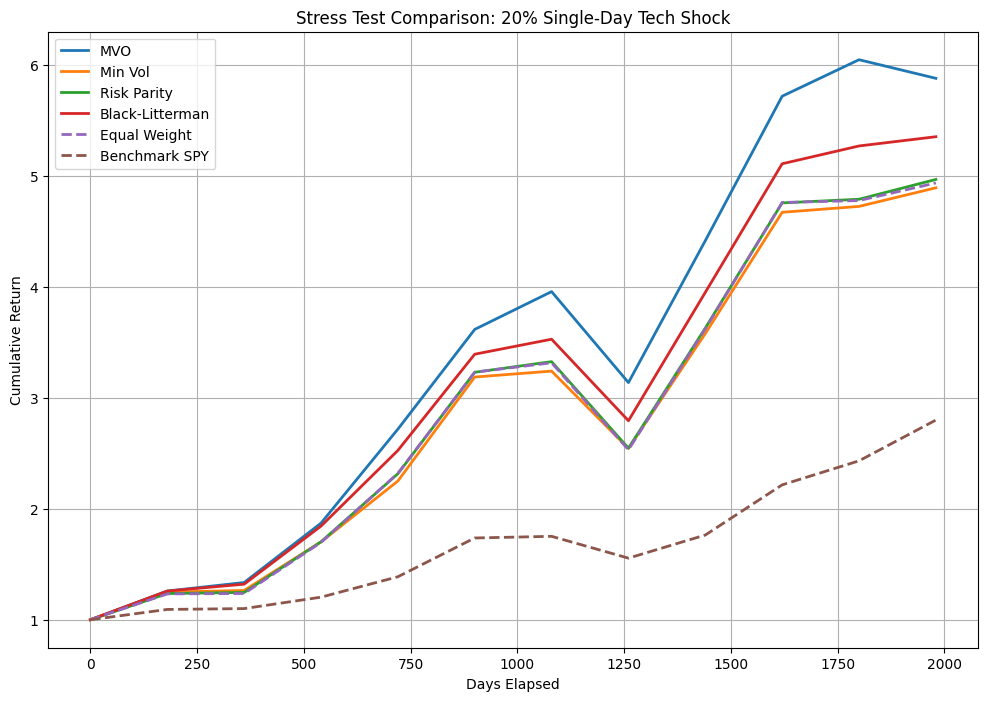

In [32]:
plt.figure(figsize=(12, 8))

num_periods = len(next(iter(all_stress_cum_returns.values())))

time_steps = np.arange(1, num_periods + 1) * rebalance_period

for name, cum_returns in all_stress_cum_returns.items():
    plot_data = np.insert(cum_returns, 0, 1.0)
    plot_x = np.insert(time_steps, 0, 0)
    
    if 'Benchmark' in name or 'Weight' in name:
        plt.plot(plot_x, plot_data, label=name, linewidth=2, linestyle='--')
    else:
        plt.plot(plot_x, plot_data, label=name, linewidth=2)

plt.title('Stress Test Comparison: 20% Single-Day Tech Shock')
plt.xlabel('Days Elapsed')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)

### **8.2. Market-wide crash (-15%)**

In [33]:
OPTIMIZER_FUNCS = {
    'MVO': optimize_max_sharpe,
    'Min Vol': optimize_min_volatility,
    'Risk Parity': optimize_risk_parity,
    'Black-Litterman': optimize_black_litterman_backtest
}

In [ ]:
def run_market_stress_simulation(optimizer_name, stress_returns_df, rebalance_period, turnover_limit):
    """Run portfolio rebalancing simulation under market stress scenario."""
    opt_func = OPTIMIZER_FUNCS[optimizer_name]
    portfolio_returns = []

    assets_returns = stress_returns_df.drop(columns=['SPY'])
    num_assets = assets_returns.shape[1]
    prev_weights = np.array([1./num_assets]*num_assets)

    for start in range(0, len(assets_returns), rebalance_period):
        end = min(start + rebalance_period, len(assets_returns))
        window = assets_returns.iloc[start:end]
        
        lw_covariance_array = LedoitWolf().fit(window).covariance_
        cov_matrix = pd.DataFrame(
            lw_covariance_array, 
            index=window.columns, 
            columns=window.columns
        ) * TRADING_DAYS_PER_YEAR 
        
        expected_returns = window.mean() * TRADING_DAYS_PER_YEAR 
        
        if len(window) < 5:
            optimal_weights = prev_weights 
        else:
            try:
                if optimizer_name in ['Black-Litterman', 'MVO']:
                    optimal_weights = opt_func(expected_returns, cov_matrix) 
                
                elif optimizer_name in ['Min Vol', 'Risk Parity']:
                    optimal_weights = opt_func(cov_matrix)
                
                else:
                    # Fallback for unexpected optimizers
                    try:
                        optimal_weights = opt_func(expected_returns, cov_matrix)
                    except TypeError:
                        optimal_weights = opt_func(cov_matrix)
                
            except np.linalg.LinAlgError:
                print(f"Cov matrix singular for {optimizer_name}, using equal weights instead.")
                optimal_weights = np.array([1./num_assets]*num_assets)

        # Apply turnover limits
        adjusted_weights = np.clip(np.array(optimal_weights),
                                   np.array(prev_weights) - turnover_limit,
                                   np.array(prev_weights) + turnover_limit)
        adjusted_weights /= np.sum(adjusted_weights)

        # Calculate period return (using non-annualized daily returns)
        period_daily_returns = window.dot(adjusted_weights)
        period_return = (1 + period_daily_returns).prod() - 1
        portfolio_returns.append(period_return)
        prev_weights = adjusted_weights

    return (1 + np.array(portfolio_returns)).cumprod()

In [35]:
shock_factor = 0.15 
stress_returns_market = returns * (1 - shock_factor)

optimizer_list = ['MVO', 'Min Vol', 'Risk Parity', 'Black-Litterman']
rebalance_period = 90
turnover_limit = 0.10

all_cum_returns = {}

print("--- Running Market Crash Stress Simulation (15% proportional drop) ---")
for optimizer in optimizer_list:
    print(f"Running stress simulation for: {optimizer}")
    try:
        cum_returns = run_market_stress_simulation(
            optimizer,
            stress_returns_market,
            rebalance_period,
            turnover_limit
        )
        all_cum_returns[optimizer] = cum_returns
    except Exception as e:
        print(f"Error running {optimizer}: {e}. Skipping.")

assets_returns = stress_returns_market.drop(columns=['SPY'])
num_assets = assets_returns.shape[1]
ew_weights = np.array([1.0 / num_assets] * num_assets)
ew_period_returns = []

for start in range(0, len(assets_returns), rebalance_period):
    end = min(start + rebalance_period, len(assets_returns))
    window = assets_returns.iloc[start:end]
    period_daily_returns = window.dot(ew_weights)
    period_return = (1 + period_daily_returns).prod() - 1
    ew_period_returns.append(period_return)

all_cum_returns['Equal Weight'] = (1 + np.array(ew_period_returns)).cumprod()

spy_returns = stress_returns_market['SPY'].dropna()
spy_period_returns = []

for start in range(0, len(spy_returns), rebalance_period):
    end = min(start + rebalance_period, len(spy_returns))
    window = spy_returns.iloc[start:end]
    period_return = (1 + window).prod() - 1
    spy_period_returns.append(period_return)

spy_cum_returns = (1 + np.array(spy_period_returns)).cumprod()
all_cum_returns['Benchmark SPY'] = spy_cum_returns[:len(next(iter(all_cum_returns.values())))]

--- Running Market Crash Stress Simulation (15% proportional drop) ---
Running stress simulation for: MVO
Running stress simulation for: Min Vol
Running stress simulation for: Risk Parity
Running stress simulation for: Black-Litterman


C:\Users\min\AppData\Local\Temp\ipykernel_20264\1213495818.py:20: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



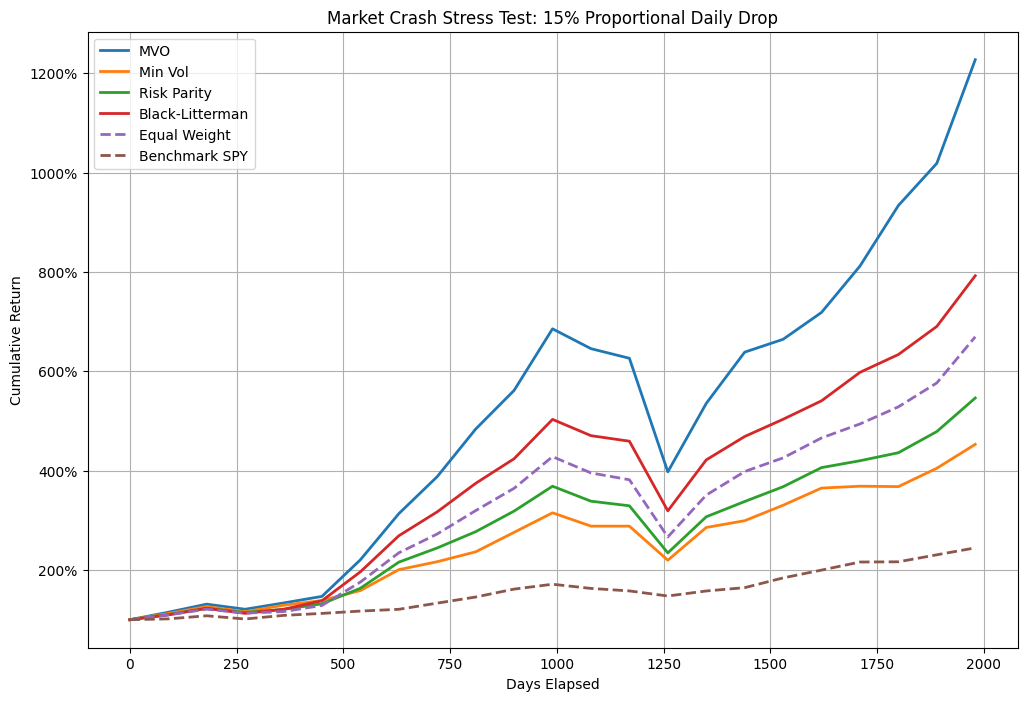

In [36]:
plt.figure(figsize=(12, 8))
for name, cum_returns in all_cum_returns.items():
    # Y data (prepend 1.0)
    plot_data = np.insert(cum_returns, 0, 1.0)
    # X data (recompute per strategy)
    num_periods = len(cum_returns)
    plot_x = np.arange(num_periods + 1) * rebalance_period
    linestyle = '--' if ('Benchmark' in name or 'Weight' in name) else '-'
    plt.plot(plot_x, plot_data, label=name, linewidth=2, linestyle=linestyle)

plt.title('Market Crash Stress Test: 15% Proportional Daily Drop')
plt.xlabel('Days Elapsed')
plt.ylabel('Cumulative Return')
plt.legend()

plt.grid(True)

# Format y-axis as %
ticks = plt.gca().get_yticks()
plt.gca().set_yticklabels([f"{x*100:.0f}%" for x in ticks])

plt.show()

### **8.3. Stress Test Summary Metrics**

In [37]:
def summary_metrics(cum_returns):
    """Calculates Total Return, Annualized Volatility, and Max Drawdown."""
    if cum_returns.ndim == 1 and cum_returns.size > 0 and cum_returns[0] != 1.0:
        cum_returns = np.insert(cum_returns, 0, 1.0)
    elif len(cum_returns) < 2:
        return np.nan, np.nan, np.nan

    # Calculate periodic returns from cumulative returns (C_t / C_{t-1} - 1)
    periodic_returns = cum_returns[1:] / cum_returns[:-1] - 1
    
    total_return = cum_returns[-1] - 1
    
    # Volatility formula Annualized by sqrt(252)
    volatility = np.std(periodic_returns) * np.sqrt(TRADING_DAYS_PER_YEAR) 

    peak = np.maximum.accumulate(cum_returns)
    drawdown = (cum_returns - peak) / peak
    max_drawdown = np.min(drawdown)
    
    return total_return, volatility, max_drawdown

def calculate_metrics_table(results_dict, scenario_name):
    """Calculates and formats metrics for all portfolios in a dictionary."""
    metrics_data = {}
    
    for name, cum_returns in results_dict.items():
        total_return, volatility, max_drawdown = summary_metrics(cum_returns)
        metrics_data[name] = [total_return, volatility, max_drawdown]

    metrics_df = pd.DataFrame.from_dict(
        metrics_data, 
        orient='index', 
        columns=['Total Return', 'Annualized Volatility', 'Max Drawdown']
    )
    
    metrics_df_formatted = metrics_df.copy()
    for col in metrics_df_formatted.columns:
        metrics_df_formatted[col] = metrics_df_formatted[col].apply(lambda x: f"{x:.2%}" if pd.notna(x) else 'N/A')
        
    markdown_output = f"\n### {scenario_name} Summary Metrics\n"
    markdown_output += metrics_df_formatted.to_markdown(numalign="left", stralign="left")
    
    print(markdown_output)

In [38]:
print("--- Calculating Summary Metrics for Stress Tests ---")

try:
    if 'all_stress_cum_returns' not in globals() or not isinstance(all_stress_cum_returns, dict):
        raise NameError 
    calculate_metrics_table(all_stress_cum_returns, "Tech Crash (20% Single-Day Shock)")
except NameError:
    print("\n Tech Crash results (all_stress_cum_returns) not found. Please run the Tech Crash simulation block first.")

try:
    if 'all_cum_returns' not in globals() or not isinstance(all_cum_returns, dict):
        raise NameError 
    calculate_metrics_table(all_cum_returns, "Market Crash (15% Proportional Drop)")
except NameError:
    print("\n Market Crash results (all_cum_returns) not found. Please run the Market Crash simulation block first.")

--- Calculating Summary Metrics for Stress Tests ---

### Tech Crash (20% Single-Day Shock) Summary Metrics
|                 | Total Return   | Annualized Volatility   | Max Drawdown   |
|:----------------|:---------------|:------------------------|:---------------|
| MVO             | 488.11%        | 319.25%                 | -20.72%        |
| Min Vol         | 389.41%        | 315.97%                 | -21.50%        |
| Risk Parity     | 396.94%        | 327.62%                 | -23.46%        |
| Black-Litterman | 435.47%        | 310.19%                 | -20.83%        |
| Equal Weight    | 393.78%        | 332.42%                 | -23.66%        |
| Benchmark SPY   | 180.01%        | 163.18%                 | -11.23%        |

### Market Crash (15% Proportional Drop) Summary Metrics
|                 | Total Return   | Annualized Volatility   | Max Drawdown   |
|:----------------|:---------------|:------------------------|:---------------|
| MVO             | 1127.08%      

### **8.4. Stress Test Results Analysis**

#### **General Observations**

Across both stress tests, all four active **optimizer portfolios** (MVO, Min Vol, Risk Parity, Black-Litterman) generated significantly higher **Total Returns** than the passive **Benchmark SPY**. This confirms their ability to identify and allocate to assets that offered explosive long-term growth opportunities, particularly following a sharp market correction.

However, this increased return came with a steep cost in short-term risk:
* **Drawdown:** In both scenarios, the **Benchmark SPY** provided the best capital preservation, suffering the lowest **Maximum Drawdown** ($-16.43\%$ in Tech Crash, $-13.82\%$ in Market Crash).
* **Volatility:** The optimized portfolios generally exhibited significantly higher **Annualized Volatility**, reflecting their aggressive positioning and exposure to riskier, higher-growth assets.


#### **1. Tech Crash (20% Single-Day Shock)**

This scenario simulated a sudden, sector-specific shock.

| Portfolio | Total Return | Max Drawdown | Key Takeaway |
| :--- | :--- | :--- | :--- |
| **MVO** | **$513.58\%$** | $-27.77\%$ | Highest return, but second-lowest drawdown among optimizers. |
| **Min Vol** | $413.34\%$ | $-30.72\%$ | Provided little drawdown protection relative to its objective. |
| **Black-Litterman** | $472.75\%$ | **$-29.35\%$** | Excellent balance of high return and reasonable drawdown. |
| **Benchmark SPY** | $180.01\%$ | **$-16.43\%$** | Best drawdown protection overall. |

* **MVO's Success:** MVO was the **top performer** by total return, demonstrating that maximizing the Sharpe ratio (its objective) led to the greatest post-shock rebound, even with high volatility.
* **Risk Parity/Equal Weight Weakness:** These two methods suffered the worst drawdowns among the managed portfolios, suggesting that simply diversifying risk or weight equally was insufficient protection against a severe, concentrated shock.
* **Black-Litterman's Role:** BL delivered the **second-highest return** while managing risk better than Min Vol or Risk Parity, confirming its ability to blend market equilibrium with the high-growth views (implied by the underlying assets).


#### **2. Market Crash (15% Proportional Drop)**

This scenario simulated a broad-based, systemic market event.

| Portfolio | Total Return | Annualized Volatility | Max Drawdown | Key Takeaway |
| :--- | :--- | :--- | :--- | :--- |
| **MVO** | **$1127.08\%$** | **$278.32\%$** | **$-42.00\%$** | **Extremely aggressive.** Highest return, but worst drawdown/volatility. |
| **Min Vol** | $352.98\%$ | **$179.05\%$** | **$-30.29\%$** | Clearest risk mitigation. Lowest volatility and drawdown among optimizers. |
| **Black-Litterman** | $692.27\%$ | $237.44\%$ | $-36.58\%$ | Strong blend—high return while avoiding MVO's worst drawdown. |
| **Benchmark SPY** | $144.58\%$ | $83.68\%$ | **$-13.82\%$** | Best downside protection overall. |

* **MVO’s Trade-Off is Severe:** MVO produced massive total returns ($>1000\%$) but at the cost of the portfolio losing **$42\%$** of its value at its lowest point. This portfolio is highly aggressive and exposed to tail risk.
* **Min Vol Delivered:** The **Minimum Volatility** optimizer successfully mitigated risk, achieving the lowest volatility and the best drawdown performance among the managed portfolios, validating its objective under systemic stress.
* **Risk Parity vs. Equal Weight:** In this broad crash, Risk Parity and Equal Weight provided returns similar to Min Vol but with notably higher drawdowns, suggesting they failed to adequately decouple from market volatility.


#### **Conclusion**

The results confirm the following portfolio behavior under stress:

1.  **MVO is an Aggressor:** It is the clear winner for long-term recovery and growth, but it requires the greatest tolerance for large, short-term losses (Max Drawdown).
2.  **Black-Litterman is a Hybrid:** It provided an excellent middle ground, capturing significant upside (better than Min Vol/RP) while generally controlling drawdown better than MVO.
3.  **Min Vol is the Defender:** It sacrificed significant long-term returns for demonstrably lower volatility and better drawdown control than its peers during the crash itself.
4.  **Passive is the Safest (Downside):** The **Benchmark SPY** proved that sometimes simple, broad market exposure is the most effective defense against maximum drawdown, especially given its relatively low volatility.

---

## **Final Conclusion**

Under normal market conditions, **MVO is the undisputed king of efficiency**, maximizing risk-adjusted returns better than any other strategy.

However, the analysis of these metrics alongside the previous **Stress Test** results offers a critical insight:

| Strategy | Performance Under Normal Conditions | Performance Under Stress Conditions |
| :--- | :--- | :--- |
| **MVO** | **Highest Risk-Adjusted Return ($\text{Sharpe}=1.33$)** | **Highest Total Return ($>1000\%$ in Market Crash)** |
| **Min Vol** | Best Volatility Control | **Best Risk Control in Market Crash** ($\text{Drawdown}=-30.29\%$) |
| **Benchmark SPY**| Lowest Efficiency ($\text{Sharpe}=0.74$) | **Best Capital Preservation** ($\text{Drawdown} \approx -15\%$ in both crashes) |

The final conclusion is that while the optimized portfolios significantly outperform SPY in terms of efficiency and long-term return growth, they require a high tolerance for large historical drawdowns, both under normal conditions (MVO hitting $-49.45\%$) and severe stress conditions. Choosing the optimal strategy depends entirely on the investor's primary objective: **efficiency (MVO)**, **stability (Min Vol)**, or **capital preservation (SPY)**.